### まずは先人のコードを理解
Ref:https://github.com/smurakami/study-ransac/blob/master/ransac.ipynb

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# 正解値
_a = 0.5
_b = 0.3

In [3]:
# サンプルデータ
points = np.array([[x, _a * x + _b + .1 * np.random.randn() + (np.random.randint(100) == 0) * np.random.rand() * 1000] for x in np.arange(0, 10, 0.01)])

(0.0, 10.0)

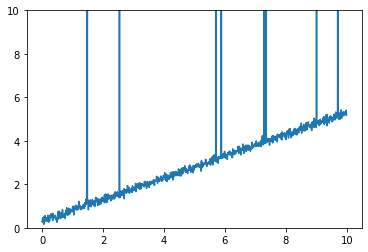

In [4]:
# 描画
plt.plot(points[:, 0], points[:, 1])
plt.ylim(0, 10)

In [5]:
data = points

In [6]:
# サンプルを使って直線のパラメータa,bを求める
def getParamWithSamples(samples):
    p0 = samples[0]
    p1 = samples[1]
    dp = p1 - p0
    a = dp[1] / dp[0]
    b = p0[1] - a * p0[0]
    return a, b
    
# モデルに当てはめる（y=ax+b）
def applyModel(model, x):
    a = model[0]
    b = model[1]
    return a * x + b

# 誤差を計算する
def getError(model, p):
    x = p[0]
    y = p[1]
    return np.abs(applyModel(model, x) - y)

# よくわからない
def errorGrad(model, data):
    a = model[0]
    b = model[1]
    x = data[:, 0]
    y = data[:, 1]
    ga = (2 * (a * x + b - y) * x).sum()
    gb = (2 * (a * x + b - y)).sum()
    return np.array([ga, gb])

# パイプライン
def ransac(data,
        # parameters for RANSAC
        n = 2, # required sample num to decide parameter
        k = 100, # max loop num
        t = 2.0, # threshold error val for inlier
        d = 800 # requrired inlier sample num to be correnct param
    ):
    
    # 変数を用意
    good_models = []
    good_model_errors = []
    iterations = 0
    
    # loop
    while iterations < k:
        # ランダムに２つデータを取り出す
        sample = data[np.random.choice(len(data), 2, False)]
        
        # 直線のパラメータを算出
        param = getParamWithSamples(sample)
        
        # 許容誤差範囲内にどれだけのデータが入っているか
        inliers = []
        for p in data:
            # 直線モデル算出に使ったデータは外す
            if (p == sample).all(1).any(): continue
                
            # 誤差を計算して許容誤差範囲を超えているか
            if getError(param, p) > t:
                continue
            else:
                # 許容誤差範囲内だったらそのデータを追加
                inliers.append(p)
        
        #  許容誤差範囲内にいくつデータが入ったか、閾値を超えているか
        if len(inliers) > d:
            # 超えていたら平均誤差を計算
            current_error = np.array([getError(param, p) for p in data]).mean()
            # とりあえずリストに追加
            good_models.append(param)
            good_model_errors.append(current_error)
        
        # 一回のループが終了
        iterations += 1
    
    # 指定回数ループが回ったら、誤差最小のモデルを返す
    best_index = np.argmin(good_model_errors)
    return good_models[best_index]

# 最急降下法？
def leastSquare(data):
    # Simulated Annealing
    # https://qiita.com/ShataKurashi/items/c0c6044e97fa9e4a9471
    tau = 100
    bestfit = None
    besterr = float('inf')
    model = np.zeros(2)
    while tau >= 0.0001:
        for _ in range(10):
            grad = errorGrad(model, data)
            grad /= np.linalg.norm(grad)
            grad *= -1
            model += grad * tau
            
        tau *= 0.1
    return model

In [7]:
a, b = ransac(data)
a, b

(0.4952606492000573, 0.3166325220644932)

(0.0, 10.0)

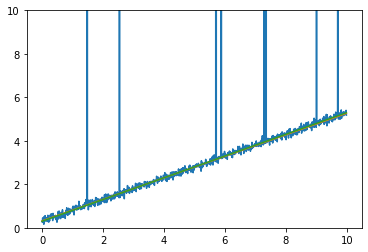

In [8]:
plt.plot(data[:, 0], data[:, 1])
l = np.array([(x, applyModel((a, b), x)) for x in data[:, 0]])
plt.plot(l[:, 0], l[:, 1])
l = np.array([(x, applyModel((_a, _b), x)) for x in data[:, 0]])
plt.plot(l[:, 0], l[:, 1])
plt.ylim(0, 10)

### 3次元に拡張してみる

In [9]:
# 正解値
_a = 1
_b = -6
_c = 0
_d = 6

In [10]:
# サンプルデータ
points = np.array([[x, _a * x**3 + _b * x**2 + _c * x + _d + .1 * np.random.randn() + (np.random.randint(100) == 0) * np.random.rand() * 1000] for x in np.arange(0, 10, 0.01)])

(-50.0, 100.0)

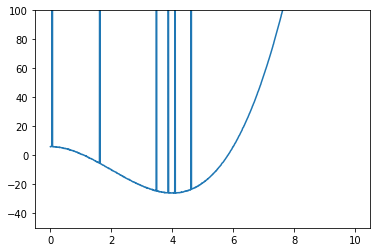

In [11]:
# 描画
plt.plot(points[:, 0], points[:, 1])
plt.ylim(-50, 100)

In [12]:
data = points

In [13]:
data.shape

(1000, 2)

In [14]:
# サンプルを使って直線のパラメータa,bを求める
def getParamWithSamples(samples):
    p0 = samples[0]
    p1 = samples[1]
    p2 = samples[2]
    p3 = samples[3]
    
    # 行列式による連立方程式の解導出
    Y = np.array([
        [p0[1]], 
        [p1[1]], 
        [p2[1]],
        [p3[1]]
    ])
    X = np.array([
        [p0[0]**3, p0[0]**2, p0[0], 1],
        [p1[0]**3, p1[0]**2, p1[0], 1],
        [p2[0]**3, p2[0]**2, p2[0], 1],
        [p3[0]**3, p3[0]**2, p3[0], 1]
    ])
    param = np.dot(np.linalg.inv(X),Y)
    
    return param[0], param[1], param[2], param[3]
    
# モデルに当てはめる（y=ax^3+bx^2+cx+d）
def applyModel(model, x):
    a = model[0]
    b = model[1]
    c = model[2]
    d = model[3]
    return a * x**3 + b * x**2 + c * x + d

# 誤差を計算する
def getError(model, p):
    x = p[0]
    y = p[1]
    return np.abs(applyModel(model, x) - y)

# パイプライン
def ransac(data,
        # parameters for RANSAC
        n = 4, # required sample num to decide parameter
        k = 100, # max loop num
        t = 2.0, # threshold error val for inlier
        d = 800 # requrired inlier sample num to be correnct param
    ):
    
    # 変数を用意
    good_models = []
    good_model_errors = []
    iterations = 0
    
    # loop
    while iterations < k:
        # ランダムに4つデータを取り出す
        sample = data[np.random.choice(len(data), 4, False)]
        
        # 直線のパラメータを算出
        param = getParamWithSamples(sample)
        
        # 許容誤差範囲内にどれだけのデータが入っているか
        inliers = []
        for p in data:
            # 直線モデル算出に使ったデータは外す
            if (p == sample).all(1).any(): continue
                
            # 誤差を計算して許容誤差範囲を超えているか
            if getError(param, p) > t:
                continue
            else:
                # 許容誤差範囲内だったらそのデータを追加
                inliers.append(p)
        
        print("inliers : ")
        print(len(inliers))
        
        #  許容誤差範囲内にいくつデータが入ったか、閾値を超えているか
        if len(inliers) > d:
            # 超えていたら平均誤差を計算
            current_error = np.array([getError(param, p) for p in data]).mean()
            # とりあえずリストに追加
            good_models.append(param)
            good_model_errors.append(current_error)
        
        # 一回のループが終了
        iterations += 1
        print("iterations : ")
        print(iterations)
        print("good_model_errors : ")
        print(good_model_errors)
    
    # 指定回数ループが回ったら、誤差最小のモデルを返す
    best_index = np.argmin(good_model_errors)
    return good_models[best_index]

In [15]:
a, b, c, d = ransac(data, t=1.0, d=300)

inliers : 
622
iterations : 
1
good_model_errors : 
[6.510771660455001]
inliers : 
212
iterations : 
2
good_model_errors : 
[6.510771660455001]
inliers : 
656
iterations : 
3
good_model_errors : 
[6.510771660455001, 5.877763612742388]
inliers : 
0
iterations : 
4
good_model_errors : 
[6.510771660455001, 5.877763612742388]
inliers : 
928
iterations : 
5
good_model_errors : 
[6.510771660455001, 5.877763612742388, 4.347910666033129]
inliers : 
859
iterations : 
6
good_model_errors : 
[6.510771660455001, 5.877763612742388, 4.347910666033129, 4.566120322724477]
inliers : 
989
iterations : 
7
good_model_errors : 
[6.510771660455001, 5.877763612742388, 4.347910666033129, 4.566120322724477, 4.224527223039056]
inliers : 
448
iterations : 
8
good_model_errors : 
[6.510771660455001, 5.877763612742388, 4.347910666033129, 4.566120322724477, 4.224527223039056, 5.372324571185249]
inliers : 
632
iterations : 
9
good_model_errors : 
[6.510771660455001, 5.877763612742388, 4.347910666033129, 4.5661203227

inliers : 
989
iterations : 
32
good_model_errors : 
[6.510771660455001, 5.877763612742388, 4.347910666033129, 4.566120322724477, 4.224527223039056, 5.372324571185249, 4.915032377876007, 4.190614166064129, 11.358716682614913, 4.414947667133194, 21.161776243573758, 4.201750569162936, 5.407090538058016, 4.201442849650839, 4.280842223394351, 4.286071706998621, 6.029027098404248, 4.184923250206541, 4.591629275399169, 4.3641814975155535, 4.331138546124122, 4.1950719527133336, 4.449302191691466, 4.727309377879211, 4.41850390810635, 5.066071039446886, 4.189773034981955, 4.2145459141300465, 4.276820204772295]
inliers : 
989
iterations : 
33
good_model_errors : 
[6.510771660455001, 5.877763612742388, 4.347910666033129, 4.566120322724477, 4.224527223039056, 5.372324571185249, 4.915032377876007, 4.190614166064129, 11.358716682614913, 4.414947667133194, 21.161776243573758, 4.201750569162936, 5.407090538058016, 4.201442849650839, 4.280842223394351, 4.286071706998621, 6.029027098404248, 4.1849232502

iterations : 
44
good_model_errors : 
[6.510771660455001, 5.877763612742388, 4.347910666033129, 4.566120322724477, 4.224527223039056, 5.372324571185249, 4.915032377876007, 4.190614166064129, 11.358716682614913, 4.414947667133194, 21.161776243573758, 4.201750569162936, 5.407090538058016, 4.201442849650839, 4.280842223394351, 4.286071706998621, 6.029027098404248, 4.184923250206541, 4.591629275399169, 4.3641814975155535, 4.331138546124122, 4.1950719527133336, 4.449302191691466, 4.727309377879211, 4.41850390810635, 5.066071039446886, 4.189773034981955, 4.2145459141300465, 4.276820204772295, 4.246722963133888, 4.2245779191359665, 11.678387419092369, 4.6687924487102475, 4.240667151619085, 6.668352914897288, 4.174989415798163, 4.192704164334298, 4.411900219569438, 5.040409257440429, 5.179035894500643]
inliers : 
918
iterations : 
45
good_model_errors : 
[6.510771660455001, 5.877763612742388, 4.347910666033129, 4.566120322724477, 4.224527223039056, 5.372324571185249, 4.915032377876007, 4.19061

iterations : 
56
good_model_errors : 
[6.510771660455001, 5.877763612742388, 4.347910666033129, 4.566120322724477, 4.224527223039056, 5.372324571185249, 4.915032377876007, 4.190614166064129, 11.358716682614913, 4.414947667133194, 21.161776243573758, 4.201750569162936, 5.407090538058016, 4.201442849650839, 4.280842223394351, 4.286071706998621, 6.029027098404248, 4.184923250206541, 4.591629275399169, 4.3641814975155535, 4.331138546124122, 4.1950719527133336, 4.449302191691466, 4.727309377879211, 4.41850390810635, 5.066071039446886, 4.189773034981955, 4.2145459141300465, 4.276820204772295, 4.246722963133888, 4.2245779191359665, 11.678387419092369, 4.6687924487102475, 4.240667151619085, 6.668352914897288, 4.174989415798163, 4.192704164334298, 4.411900219569438, 5.040409257440429, 5.179035894500643, 4.401061424042709, 4.220142620912723, 4.220380120286143, 5.369298815096182, 11.832421913439147, 4.323105554681731, 30.201652839121568, 4.412391754693395, 4.249842444243406, 4.2325179382837215, 5

iterations : 
65
good_model_errors : 
[6.510771660455001, 5.877763612742388, 4.347910666033129, 4.566120322724477, 4.224527223039056, 5.372324571185249, 4.915032377876007, 4.190614166064129, 11.358716682614913, 4.414947667133194, 21.161776243573758, 4.201750569162936, 5.407090538058016, 4.201442849650839, 4.280842223394351, 4.286071706998621, 6.029027098404248, 4.184923250206541, 4.591629275399169, 4.3641814975155535, 4.331138546124122, 4.1950719527133336, 4.449302191691466, 4.727309377879211, 4.41850390810635, 5.066071039446886, 4.189773034981955, 4.2145459141300465, 4.276820204772295, 4.246722963133888, 4.2245779191359665, 11.678387419092369, 4.6687924487102475, 4.240667151619085, 6.668352914897288, 4.174989415798163, 4.192704164334298, 4.411900219569438, 5.040409257440429, 5.179035894500643, 4.401061424042709, 4.220142620912723, 4.220380120286143, 5.369298815096182, 11.832421913439147, 4.323105554681731, 30.201652839121568, 4.412391754693395, 4.249842444243406, 4.2325179382837215, 5

iterations : 
74
good_model_errors : 
[6.510771660455001, 5.877763612742388, 4.347910666033129, 4.566120322724477, 4.224527223039056, 5.372324571185249, 4.915032377876007, 4.190614166064129, 11.358716682614913, 4.414947667133194, 21.161776243573758, 4.201750569162936, 5.407090538058016, 4.201442849650839, 4.280842223394351, 4.286071706998621, 6.029027098404248, 4.184923250206541, 4.591629275399169, 4.3641814975155535, 4.331138546124122, 4.1950719527133336, 4.449302191691466, 4.727309377879211, 4.41850390810635, 5.066071039446886, 4.189773034981955, 4.2145459141300465, 4.276820204772295, 4.246722963133888, 4.2245779191359665, 11.678387419092369, 4.6687924487102475, 4.240667151619085, 6.668352914897288, 4.174989415798163, 4.192704164334298, 4.411900219569438, 5.040409257440429, 5.179035894500643, 4.401061424042709, 4.220142620912723, 4.220380120286143, 5.369298815096182, 11.832421913439147, 4.323105554681731, 30.201652839121568, 4.412391754693395, 4.249842444243406, 4.2325179382837215, 5

inliers : 
894
iterations : 
81
good_model_errors : 
[6.510771660455001, 5.877763612742388, 4.347910666033129, 4.566120322724477, 4.224527223039056, 5.372324571185249, 4.915032377876007, 4.190614166064129, 11.358716682614913, 4.414947667133194, 21.161776243573758, 4.201750569162936, 5.407090538058016, 4.201442849650839, 4.280842223394351, 4.286071706998621, 6.029027098404248, 4.184923250206541, 4.591629275399169, 4.3641814975155535, 4.331138546124122, 4.1950719527133336, 4.449302191691466, 4.727309377879211, 4.41850390810635, 5.066071039446886, 4.189773034981955, 4.2145459141300465, 4.276820204772295, 4.246722963133888, 4.2245779191359665, 11.678387419092369, 4.6687924487102475, 4.240667151619085, 6.668352914897288, 4.174989415798163, 4.192704164334298, 4.411900219569438, 5.040409257440429, 5.179035894500643, 4.401061424042709, 4.220142620912723, 4.220380120286143, 5.369298815096182, 11.832421913439147, 4.323105554681731, 30.201652839121568, 4.412391754693395, 4.249842444243406, 4.2325

inliers : 
106
iterations : 
88
good_model_errors : 
[6.510771660455001, 5.877763612742388, 4.347910666033129, 4.566120322724477, 4.224527223039056, 5.372324571185249, 4.915032377876007, 4.190614166064129, 11.358716682614913, 4.414947667133194, 21.161776243573758, 4.201750569162936, 5.407090538058016, 4.201442849650839, 4.280842223394351, 4.286071706998621, 6.029027098404248, 4.184923250206541, 4.591629275399169, 4.3641814975155535, 4.331138546124122, 4.1950719527133336, 4.449302191691466, 4.727309377879211, 4.41850390810635, 5.066071039446886, 4.189773034981955, 4.2145459141300465, 4.276820204772295, 4.246722963133888, 4.2245779191359665, 11.678387419092369, 4.6687924487102475, 4.240667151619085, 6.668352914897288, 4.174989415798163, 4.192704164334298, 4.411900219569438, 5.040409257440429, 5.179035894500643, 4.401061424042709, 4.220142620912723, 4.220380120286143, 5.369298815096182, 11.832421913439147, 4.323105554681731, 30.201652839121568, 4.412391754693395, 4.249842444243406, 4.2325

iterations : 
95
good_model_errors : 
[6.510771660455001, 5.877763612742388, 4.347910666033129, 4.566120322724477, 4.224527223039056, 5.372324571185249, 4.915032377876007, 4.190614166064129, 11.358716682614913, 4.414947667133194, 21.161776243573758, 4.201750569162936, 5.407090538058016, 4.201442849650839, 4.280842223394351, 4.286071706998621, 6.029027098404248, 4.184923250206541, 4.591629275399169, 4.3641814975155535, 4.331138546124122, 4.1950719527133336, 4.449302191691466, 4.727309377879211, 4.41850390810635, 5.066071039446886, 4.189773034981955, 4.2145459141300465, 4.276820204772295, 4.246722963133888, 4.2245779191359665, 11.678387419092369, 4.6687924487102475, 4.240667151619085, 6.668352914897288, 4.174989415798163, 4.192704164334298, 4.411900219569438, 5.040409257440429, 5.179035894500643, 4.401061424042709, 4.220142620912723, 4.220380120286143, 5.369298815096182, 11.832421913439147, 4.323105554681731, 30.201652839121568, 4.412391754693395, 4.249842444243406, 4.2325179382837215, 5

In [16]:
a, b, c, d

(array([0.9988942]),
 array([-5.98248307]),
 array([-0.07528686]),
 array([6.07600197]))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


(-50.0, 100.0)

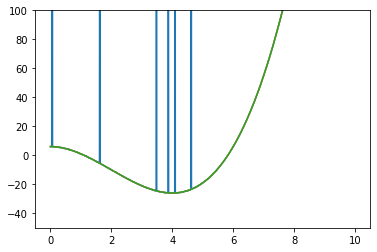

In [17]:
plt.plot(data[:, 0], data[:, 1])
l = np.array([(x, applyModel((a, b, c, d), x)) for x in data[:, 0]])
plt.plot(l[:, 0], l[:, 1])
l = np.array([(x, applyModel((_a, _b, _c, _d), x)) for x in data[:, 0]])
plt.plot(l[:, 0], l[:, 1])
plt.ylim(-50, 100)